13 Pipeline Example Demonstrating PLASMO Functionality

First, import all of our pacakages

In [2]:
push!(LOAD_PATH, pwd());
include("../src/PlaSMO_debug.jl");
include("../gas_components.jl");

Define function for:
- Fixing gas demands
- Fixing supply pressures
- Creating the 13 pipeline network using data files containing parameters and topology

In [3]:
#fix supply pressures
function fix_supply_pressure!(m::JuMP.Model,supply_nodes::Any,spressure::Number)
    for supply in supply_nodes
        junction = neighbors_out(supply)[1]
        pressure = getvariable(junction,:pressure)
        @constraint(m,fix_pressure[t = time_grid],pressure[t] == spressure)
    end
end

function fix_demands!(m::JuMP.Model,demand_nodes,demand_matrix)
    i = 1
    for node in demand_nodes
        stoch_data = demand_matrix[i,:]
        i += 1
        demand = getvariable(node,:fdemand)
        @constraint(m, fix_dem[t = time_grid],demand[t] == stoch_data[t])
    end
end

function create_13_pipe_network(node_data,link_data,supply_data,demand_data,time_grid,x_grid,horizon)
    #Create the top level gas network
    network = Graph()

    #create a dictionary to keep track of nodes {node_name:node_object}
    nodeDict = Dict()

    #Create the individual gas systems
    for row in node_data
        pmin = row["pmin"]
        pmax = row["pmax"]
        pstart = (pmin + pmax)/2
        jdata = JunctionData(time_grid,pmin,pmax,pstart)  #time grid, p_low,p_high,p_start
        node = addnode!(network)
        #addattribute!(node,:jdata,jdata)
        gassystem = GasSystem(jdata)
        nodeDict[row["NODE"]] = gassystem
        addgraph!(node,getgraph(gassystem))  #add a gas junction system to the node
        setcouplingfunction(network,gassystem.junction,couplegasnode!)
    end

    #Create gas supplies and connect them to their corresponding gas nodes
    #supply_locations = []
    supply_nodes = []
    for row in supply_data
        supply_location = row["sloc"]                #get the supply node location
        s_min =  row["smin"]
        s_max = row["smax"]*ffac*ffac2
        gassystem = nodeDict[supply_location]
        sdata = SupplyData(time_grid,0,s_min,s_max)
        snode = addsupply!(gassystem,sdata)
        addattribute!(snode,:sdata,sdata)
        push!(supply_nodes,snode)
    end

    #create the gas demands and connect them
    demand_nodes = []
    for row in demand_data
        demand_location = row["dloc"]
        gassystem = nodeDict[demand_location]
        ddata = DemandData(time_grid,-1000)
        dnode = adddemand!(gassystem,ddata)
        addattribute!(dnode,:ddata,ddata)
        push!(demand_nodes,dnode)
    end

    #create all the links
    for row in link_data
        start_junction = nodeDict[row["lstartloc"]]  #get the starting gas node
        end_junction = nodeDict[row["lendloc"]]      #get the ending gas node
        diameter = row["ldiam"]*dfac
        llength = row["llength"]*lfac
        min_pressure = 0
        max_pressure = 100
        min_flow = 0
        max_flow = 100
        dpmin = 0
        dpmax = 100
        min_power = 0
        max_power = 3000
        comp_cost = 0.1

        pdata = PipeData(llength,diameter,time_grid,x_grid,min_pressure,max_pressure,min_flow,max_flow)
        cdata = CompData(dpmin,dpmax,min_power,max_power,comp_cost)
        link = Edge(network,start_junction.junction,end_junction.junction)  #connect junctions with pipelines
        #add attributes to the link to reference them easily later
        addattribute!(link,:pdata,pdata)
        if row["ltype"] == "a"
            setmodel!(link,ssactivelink(pdata,cdata))
            addattribute!(link,:cdata,cdata)
        elseif row["ltype"] == "p"
            setmodel!(link,sspassivelink(pdata))
        else
            error("link type should be either a (active) or p (passive)")
        end
        setcouplingfunction(network,link,couplelink!)
    end
    return network,supply_nodes,demand_nodes
end


create_13_pipe_network (generic function with 1 method)

Include files containing some parsing and plotting functions

In [5]:
include("../parse_input_data.jl");
include("../write_outputs.jl");
include("plot_13_pipe.jl");

Now create the network from our data

In [6]:
time_grid = 1:24  #24 hour horizon
x_grid = 1:3      #3 grid points in every pipeline
const horizon = 24*3600  #the horizon is in seconds

#Read data files for nodes, links, supplies, and demands
nodeinfo = readdlm("DAT_13pipe_GAS/nodeinfo.tab")
linkinfo = readdlm("DAT_13pipe_GAS/linkinfo.tab")
supplyinfo = readdlm("DAT_13pipe_GAS/supinfo.tab")
demandinfo = readdlm("DAT_13pipe_GAS/demandinfo.tab")

#Parse the data into dictionaries
node_data = parsedlm(nodeinfo)
link_data = parsedlm(linkinfo)
supply_data = parsedlm(supplyinfo)
demand_data = parsedlm(demandinfo)

#create the network using our 13 pipe function
gas_network,supply_nodes,demand_nodes = create_13_pipe_network(node_data,link_data,supply_data,demand_data,time_grid,x_grid,horizon)


(graph##9128,Any[node2],Any[node2])

Solve the 13 pipeline model

In [8]:
using Ipopt
#generate an array of some constant demands
demand = fill(10*ffac*ffac2,1,48)
#Create the flattened model of the gas network
m = generatemodel!(gas_network)

# NOTE: We could have fixed demands and pressures before generating the flat model, but we can keep the graph more general if we just fix data afterwards
fix_demands!(m,demand_nodes,demand) #fix all the demand node demands using our fix_demands function
fix_supply_pressure!(m,supply_nodes,54) #fix all the supply pressures using our function

#Set the solver and solve the nonlinear program
m.solver = IpoptSolver(linear_solver = "ma57", tol = 1E-6)
solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version trunk, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    12347
Number of nonzeros in inequality constraint Jacobian.:       48
Number of nonzeros in Lagrangian Hessian.............:     4896

Total number of variables............................:     5267
                     variables with only lower bounds:     2688
                variables with lower and upper bounds:     2544
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5003
Total number of inequality constrain

:Optimal

Write out and plot the results

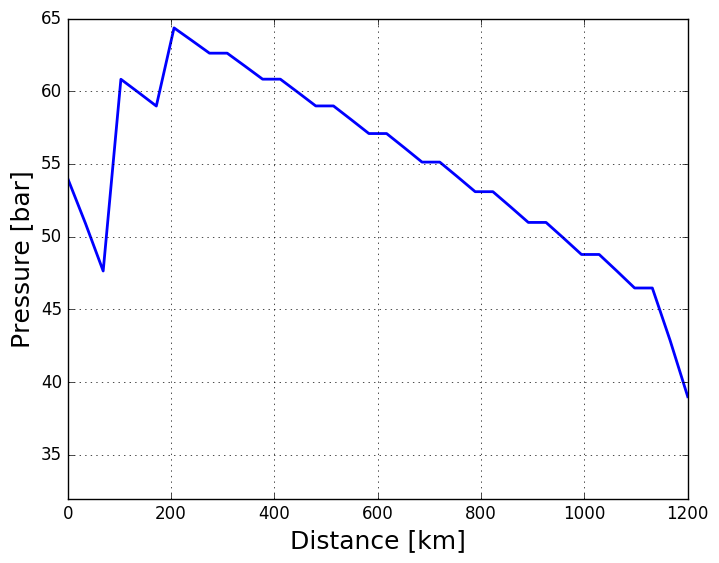

In [9]:
#write the results
fpath = "./results/gas_delivered.tab"
write_gasnet_data(gas_network,length(x_grid),length(time_grid))
#write_gas_delivered(demand_nodes,fpath)
plot_13_pipe(press_profile,length(x_grid),length(time_grid))